In [ ]:
import gym

from tqdm.notebook import tqdm
from collections import defaultdict
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import pickle

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple
from itertools import count

import cProfile
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

# from matplotlib import rc
# rc('font',**{'family':'sans-serif'})
# rc('text', usetex=True)
# rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
# rc('text.latex',preamble=r'\usepackage[russian]{babel}')
# rc('figure', **{'dpi': 300})

## Реализуем крестики-нолики

In [ ]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=3, n_cols=3, n_win=3):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
#             print((i,j))
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [ ]:
def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    '''Рисуем доску с оценками из стратегии pi'''
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q[s][i], fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
#             else:
#                 ax.text( a[1] , a[0] , "???", fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
    cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()

def get_and_print_move(env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60):
    '''Делаем ход, рисуем доску'''
    plot_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi is not None):
        if s in pi.Q:
            for i,a in enumerate(actions):
                print(i, a, pi.Q[s][i])
        else:
            print("Стратегия не знает, что делать...")
    if random:
        return np.random.randint(len(actions))
    else:
        return pi.getActionGreedy(s, len(actions))

In [1]:
def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=True, verbose=True, fontq=20, fontx=60):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose, fontq=fontq, fontx=fontx)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose, fontq=fontq, fontx=fontx)
        observation, reward, done, info = env.step(actions[a])
        if reward == 1:
            print("Крестики выиграли!")
        if reward == -1:
            print("Нолики выиграли!")
    if reward == 0:
        print("Ничья!")
    plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)

In [ ]:
def play_episode(env, pi_crosses, pi_naughts):
    done = False
    env.reset()

    s, actions = env.getHash(), env.getEmptySpaces()

    while not done:
        if env.curTurn == 1:
            action_idx = pi_crosses.getActionGreedy(s, len(actions))
            action = actions[action_idx]
        else:
            action_idx = pi_naughts.getActionGreedy(s, len(actions))
            action = actions[action_idx]
        
        (s, actions, _), reward, done, info = env.step(action)

    return reward


def validation(env, pi_crosses, pi_naughts, n_plays):
    wins_crosses, wins_naughts = 0, 0

    for i in range(n_plays):
        reward = play_episode(env, pi_crosses, pi_naughts)
        if reward == 1:
            wins_crosses += 1
        elif reward == -1:
            wins_naughts += 1
    
    return wins_crosses / n_plays, wins_naughts / n_plays

# Часть первая: крестики-нолики при помощи Q-обучения


Предполагается следующий интерфейс: класс policy должен содержать "таблицу" Q и метод getActionGreedy(state, len(actions)).
Состояние поля кодируется строкой, Q -- словарь, который по ключу-состоянию s  содержит словарь Q[s]: "индекс доступного в сост s действия: оценка этого действия в сост s". Индекс доступного в сост s действия определяется индексом этого действия в списке действий, выдаваемом env.getEmptySpaces().\
getActionGreedy(s, len(actions)) возвращает индекс действия в env.getEmptySpaces() для сост s.

In [ ]:
class TicTacToePolicy():
    def __init__(self):
        self.Q = defaultdict(lambda: defaultdict(float))

    def getActionGreedy(self, s_hash, n_actions):
        if s_hash in self.Q  and len(self.Q[s_hash]) > 0:
            return max(self.Q[s_hash], key=self.Q[s_hash].get) # argmax(Q[s_hash])
        else:
            return self.getActionRandom(n_actions)

    def getActionRandom(self, n_actions):
        return np.random.randint(n_actions)

    def getMaxActionScore(self, s_hash):
        if (s_hash not in self.Q) or (len(self.Q[s_hash]) == 0):
            return 0
        return max(self.Q[s_hash].values())

Обучаются одновременно две стратегии, играющие друг против друга.

In [ ]:
def Q_learning_episode(env, pi_crosses, pi_naughts, alpha=0.05, epsilon=0.1, gamma=0.9):
    done = False
    env.reset()

    s, actions = env.getHash(), env.getEmptySpaces()
    s_naughts, action_idx_naughts = ' ', 0 # only for the first iteration

    while not done:
        if env.curTurn == 1:
            s_crosses = s
            action_idx_crosses = pi_crosses.getActionGreedy(s, len(actions)) if np.random.rand() > epsilon \
                      else pi_crosses.getActionRandom(len(actions))
            action = actions[action_idx_crosses]

            (s, actions, _), reward, done, info = env.step(action) # s_prime, actions_prime
            # Пока для крестиков Q[s][a] можем обновить по формуле Q-обучения только частично
            # т.к. Q(S_t+1) не доступно: следующее состояние в которое попадет игрок, играющий крестиками, 
            # станет известно только после хода ноликов
            pi_crosses.Q[s_crosses][action_idx_crosses] += alpha * (reward  - pi_crosses.Q[s_crosses][action_idx_crosses])
            # Завершаем обновление Q[s][a] ноликов после хода крестиков
            pi_naughts.Q[s_naughts][action_idx_naughts] += alpha * gamma * pi_naughts.getMaxActionScore(s)
            # Если выиграли крестики, то реворд для ноликов отрицательный
            pi_naughts.Q[s_naughts][action_idx_naughts] += alpha * (-reward)
        else:
            s_naughts = s
            action_idx_naughts = pi_naughts.getActionGreedy(s, len(actions)) if np.random.rand() > epsilon \
                      else pi_naughts.getActionRandom(len(actions))
            action = actions[action_idx_naughts]
            
            (s, actions, _), reward, done, info = env.step(action) # s_prime, actions_prime
            reward = -reward # env returns -1 if the naughts win
            pi_naughts.Q[s_naughts][action_idx_naughts] += alpha * (reward - pi_naughts.Q[s_naughts][action_idx_naughts])
            # Завершаем обновление Q[s][a] крестиков после хода ноликов 
            pi_crosses.Q[s_crosses][action_idx_crosses] += alpha * gamma * pi_crosses.getMaxActionScore(s)
            # Если выиграли нолики, то реворд для крестиков отрицательный
            pi_crosses.Q[s_crosses][action_idx_crosses] += alpha * (-reward)

In [ ]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)

pi_crosses = TicTacToePolicy()
pi_naughts = TicTacToePolicy()

In [ ]:
crosses_win_rates = [validation(env, pi_crosses, TicTacToePolicy(), 1000)[0]]
crosses_loss_rates = [0]

naughts_win_rates = [validation(env, TicTacToePolicy(), pi_naughts, 1000)[1]]
naughts_loss_rates = [0]

x = [0]

for i in tqdm(range(300000)):
    Q_learning_episode(env, pi_crosses, pi_naughts, alpha=0.05, epsilon=0.3, gamma=1.0)

    if (i + 1) % 1000 == 0:
        crosses_win_rate, rand_naughts_win_rate = validation(env, pi_crosses, TicTacToePolicy(), 1000)
        crosses_win_rates.append(crosses_win_rate)
        crosses_loss_rates.append(rand_naughts_win_rate)

        rand_crosses_win_rate, naughts_win_rate = validation(env, TicTacToePolicy(), pi_naughts, 1000)
        naughts_win_rates.append(naughts_win_rate)
        naughts_loss_rates.append(rand_crosses_win_rate)
        x.append(i + 1)

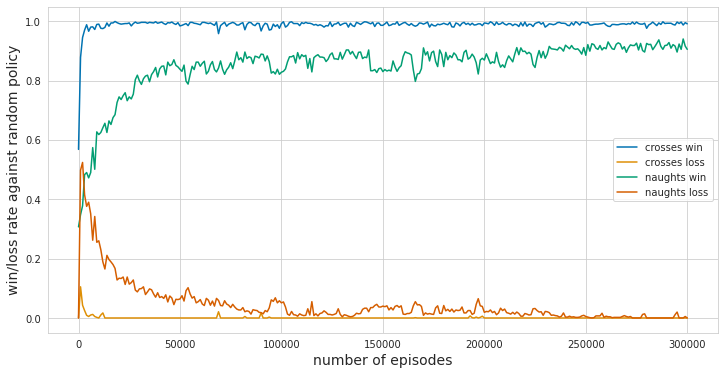

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(x, crosses_win_rates, label='crosses win')
plt.plot(x, crosses_loss_rates, label='crosses loss')
plt.plot(x, naughts_win_rates, label='naughts win')
plt.plot(x, naughts_loss_rates, label='naughts loss')
plt.xlabel('number of episodes', fontsize=14)
plt.ylabel('win/loss rate against random policy', fontsize=14)
plt.legend()
plt.show();

In [ ]:
validation(env, pi_crosses, pi_naughts, 1) # партия детерминирована

(0.0, 0.0)

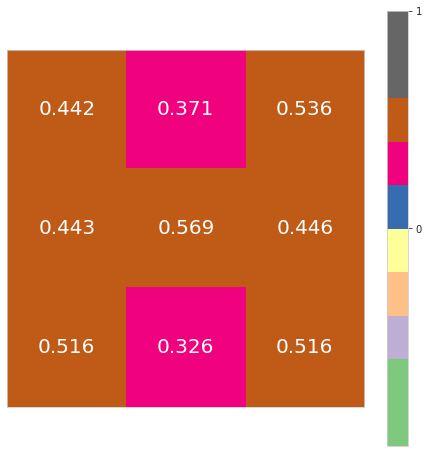

Ничья!


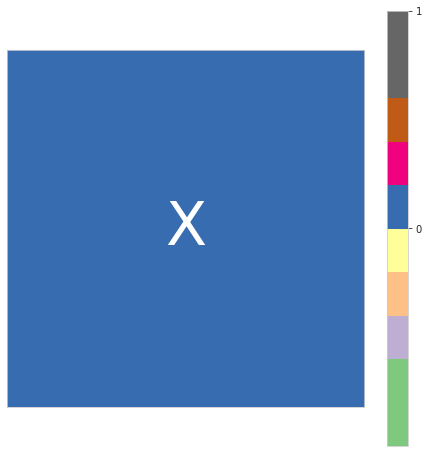

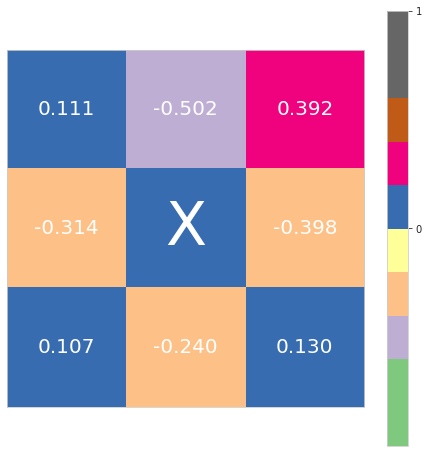

Ничья!


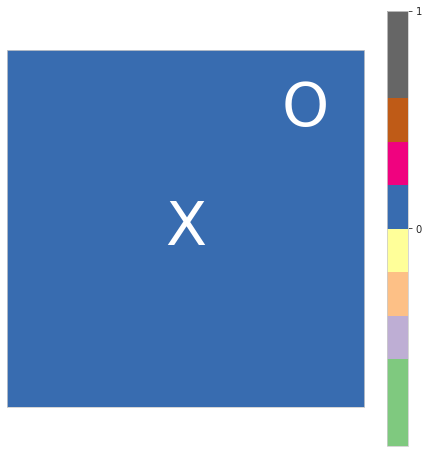

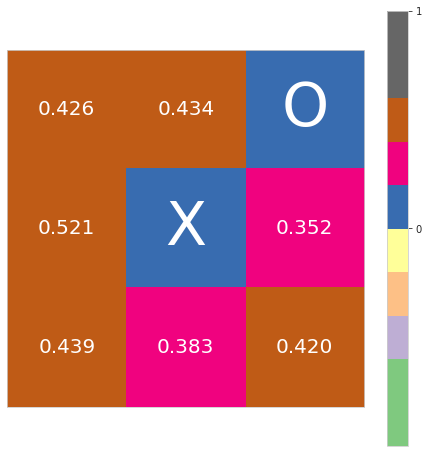

Ничья!


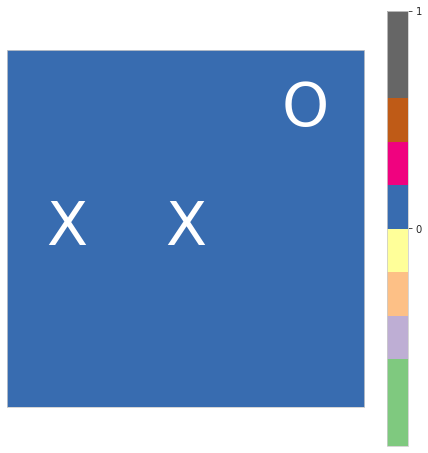

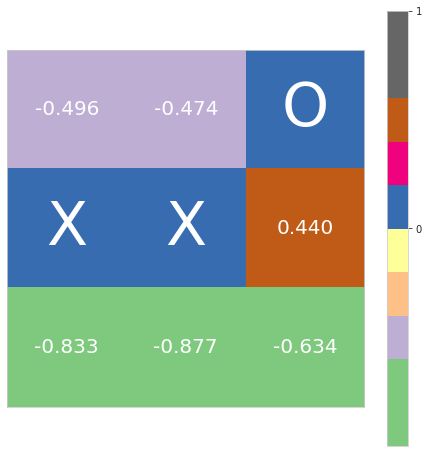

Ничья!


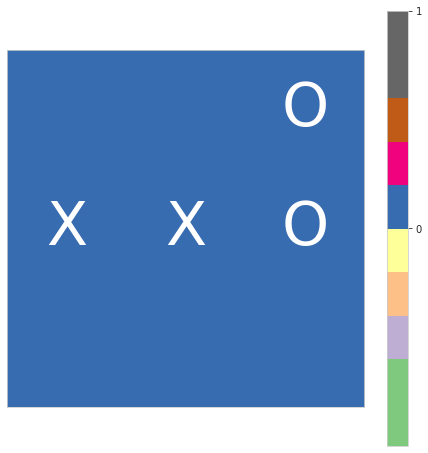

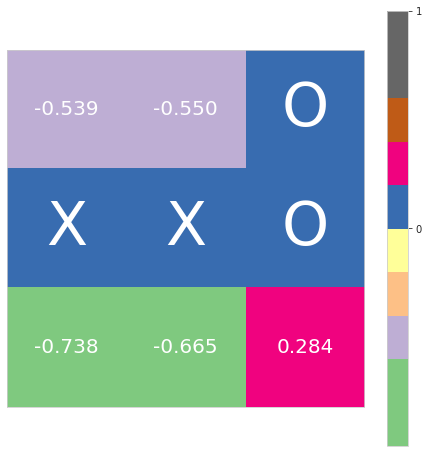

Ничья!


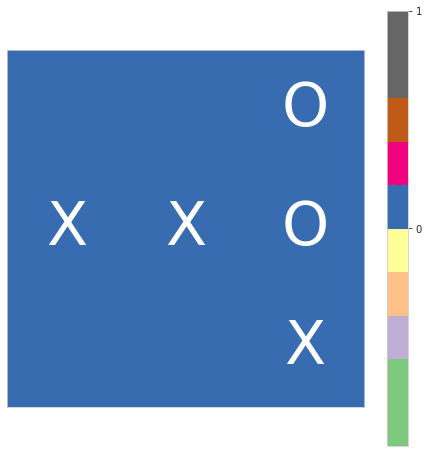

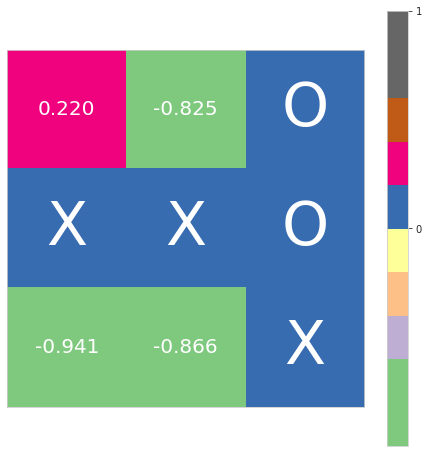

Ничья!


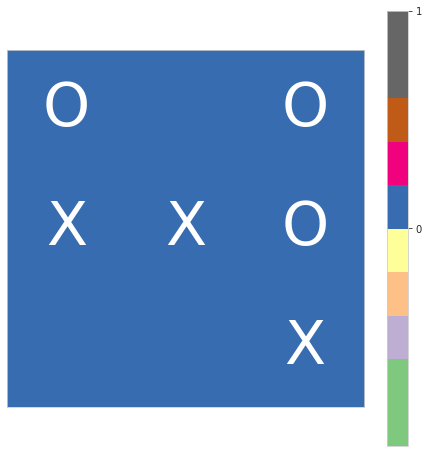

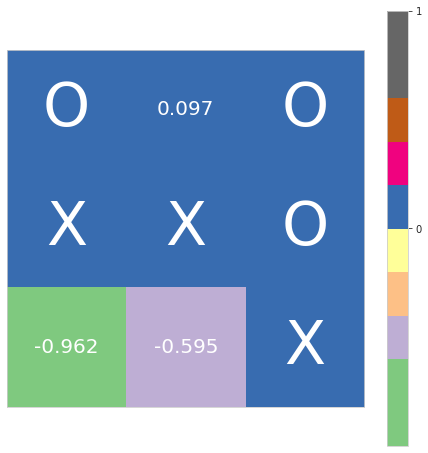

Ничья!


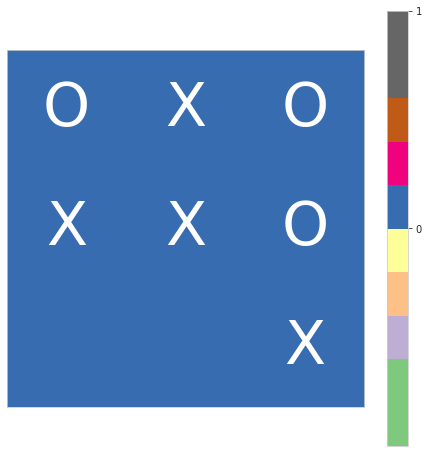

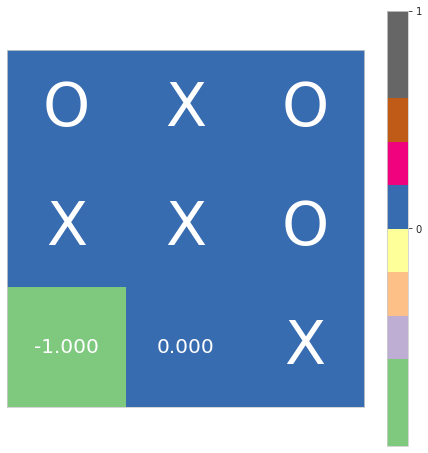

Ничья!


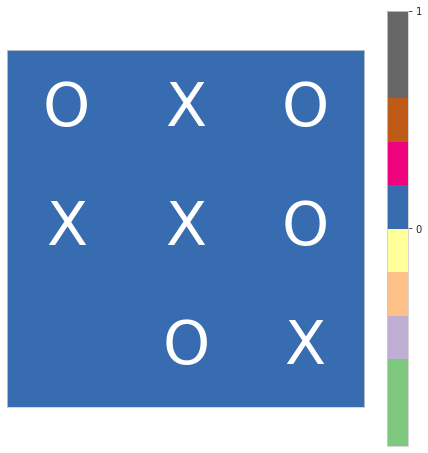

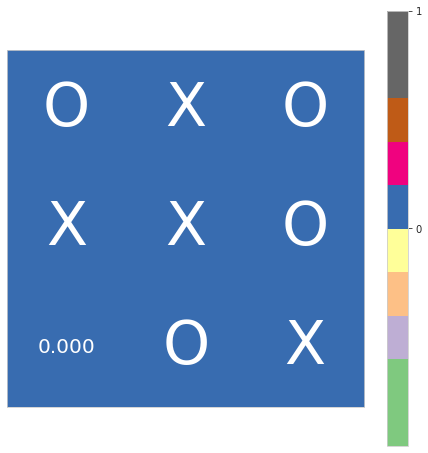

Ничья!


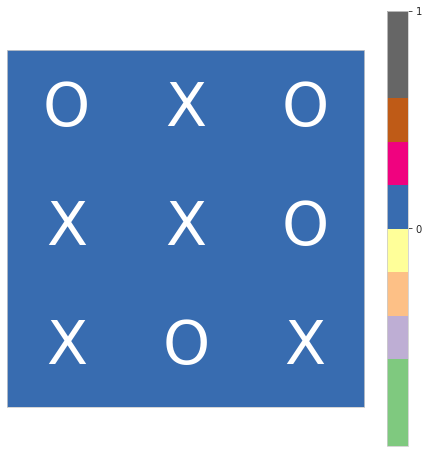

In [ ]:
plot_test_game(env, pi_crosses, pi_naughts, random_crosses=False, random_naughts=False, verbose=False, fontq=20, fontx=60)

## 4 x 4

In [ ]:
env = TicTacToe(n_rows=4, n_cols=4, n_win=4)

pi_crosses = TicTacToePolicy()
pi_naughts = TicTacToePolicy()

In [ ]:
# Рандомные крестики против рандомных ноликов
validation(env, TicTacToePolicy(), TicTacToePolicy(), 10000)

(0.3172, 0.2682)

In [ ]:
crosses_win_rates = [validation(env, pi_crosses, TicTacToePolicy(), 1000)[0]]
crosses_loss_rates = [0]

naughts_win_rates = [validation(env, TicTacToePolicy(), pi_naughts, 1000)[1]]
naughts_loss_rates = [0]

x = [0]

for i in tqdm(range(5000000)):
    Q_learning_episode(env, pi_crosses, pi_naughts, alpha=0.05, epsilon=0.3, gamma=1.0)

    if (i + 1) % 10000 == 0:
        crosses_win_rate, rand_naughts_win_rate = validation(env, pi_crosses, TicTacToePolicy(), 1000)
        crosses_win_rates.append(crosses_win_rate)
        crosses_loss_rates.append(rand_naughts_win_rate)

        rand_crosses_win_rate, naughts_win_rate = validation(env, TicTacToePolicy(), pi_naughts, 1000)
        naughts_win_rates.append(naughts_win_rate)
        naughts_loss_rates.append(rand_crosses_win_rate)
        x.append(i + 1)

Buffered data was truncated after reaching the output size limit.

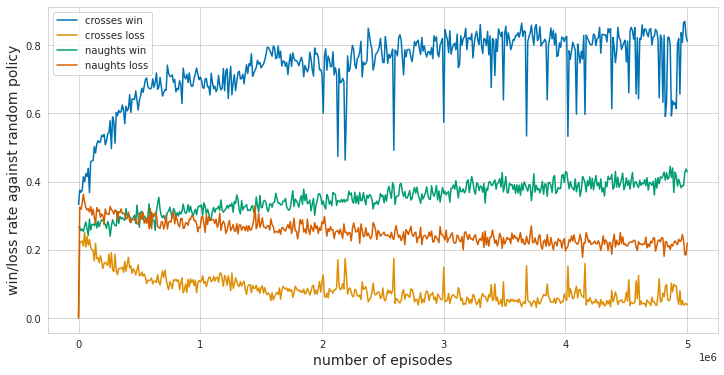

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(x, crosses_win_rates, label='crosses win')
plt.plot(x, crosses_loss_rates, label='crosses loss')
plt.plot(x, naughts_win_rates, label='naughts win')
plt.plot(x, naughts_loss_rates, label='naughts loss')
plt.xlabel('number of episodes', fontsize=14)
plt.ylabel('win/loss rate against random policy', fontsize=14)
plt.legend()
plt.show();

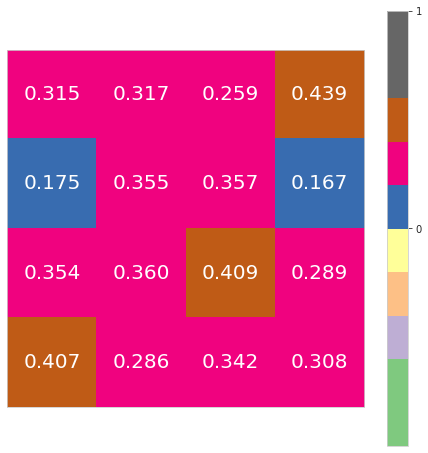

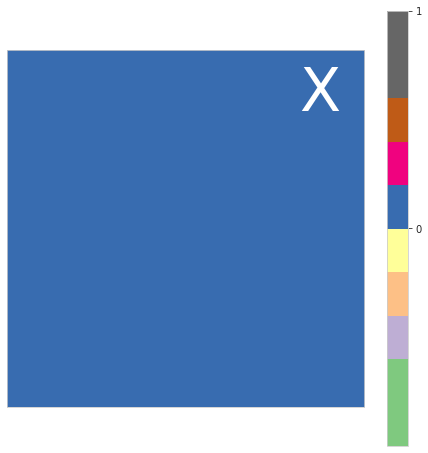

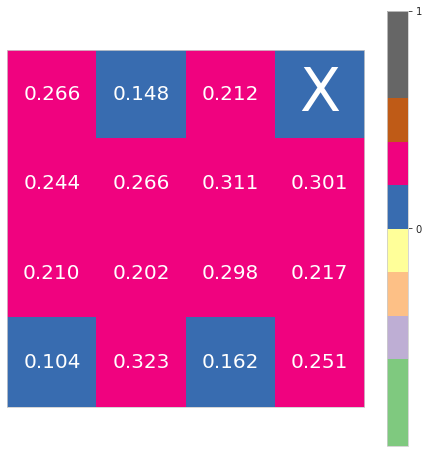

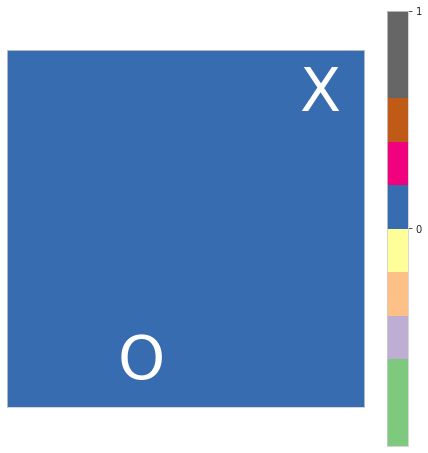

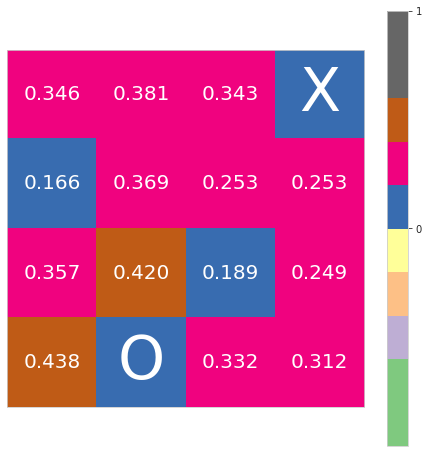

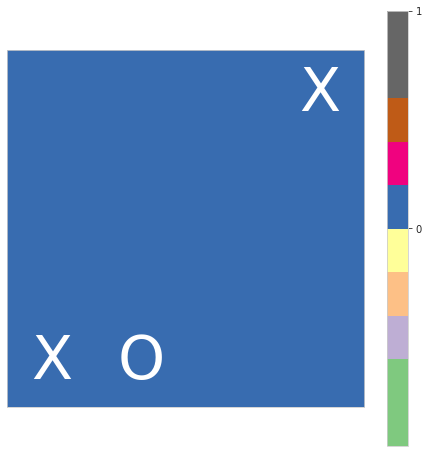

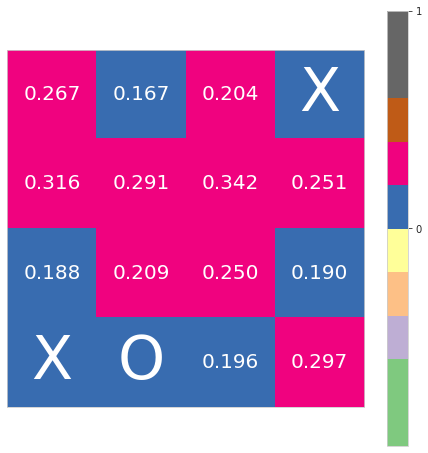

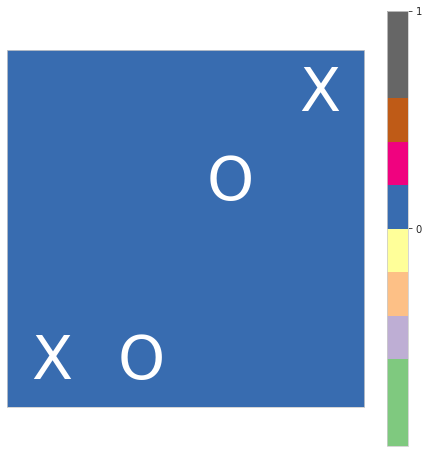

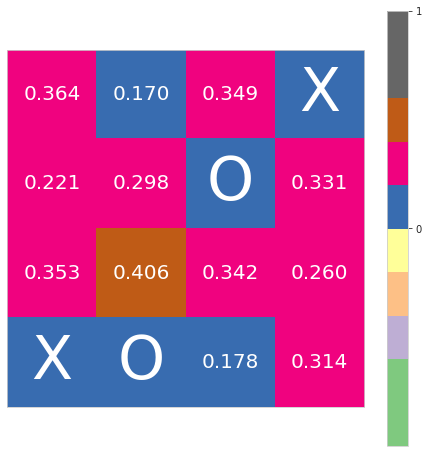

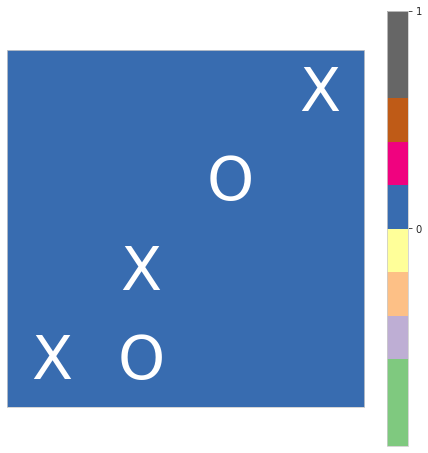

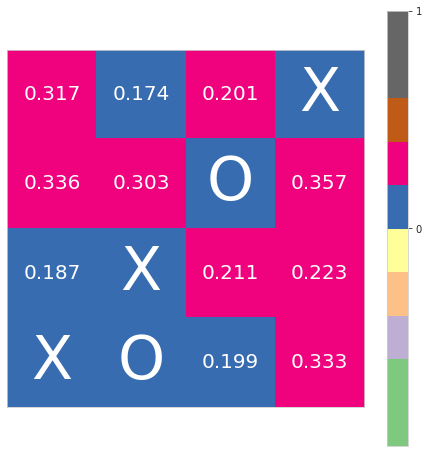

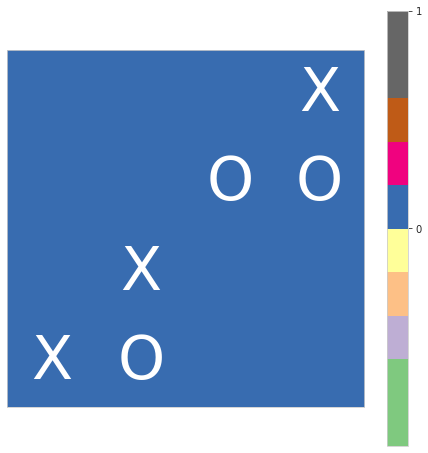

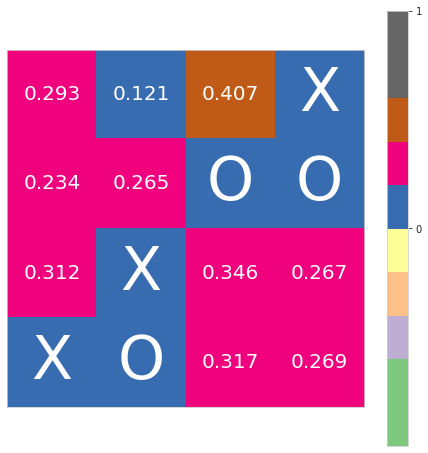

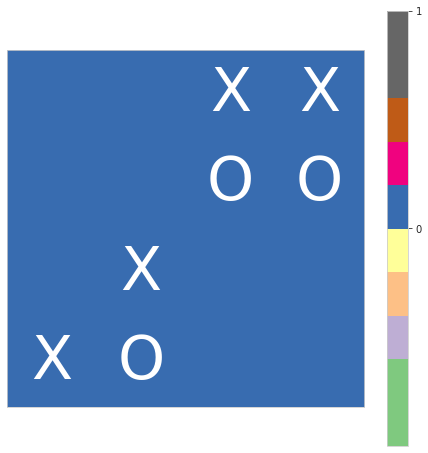

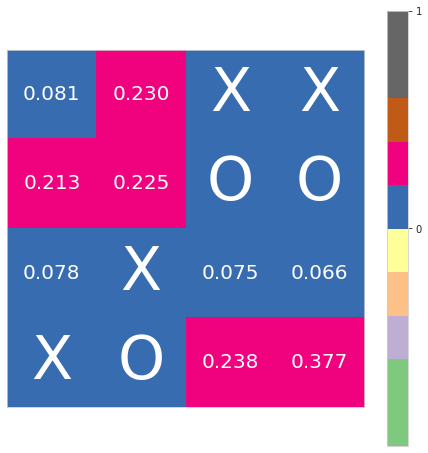

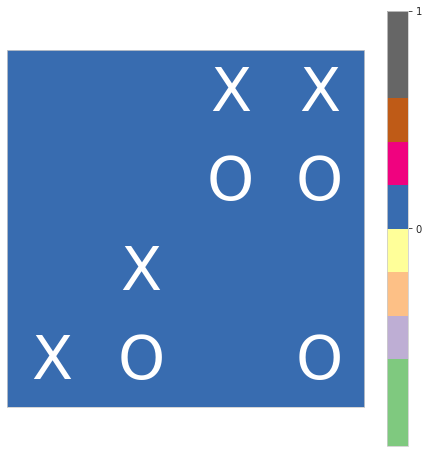

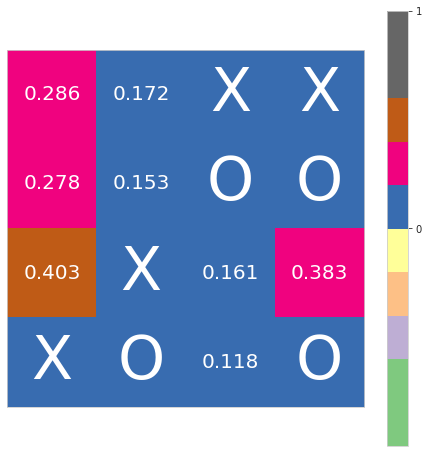

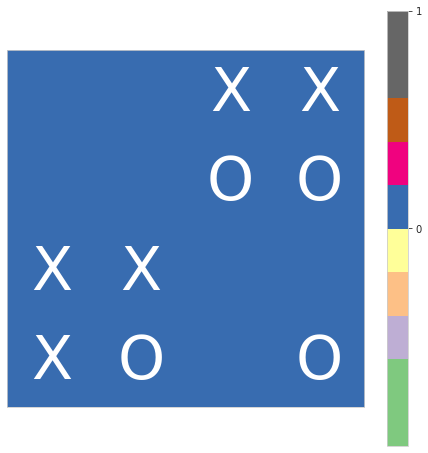

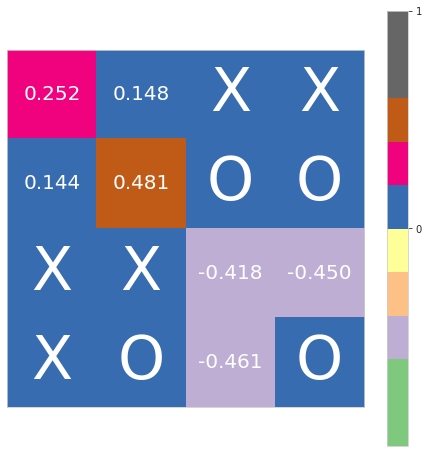

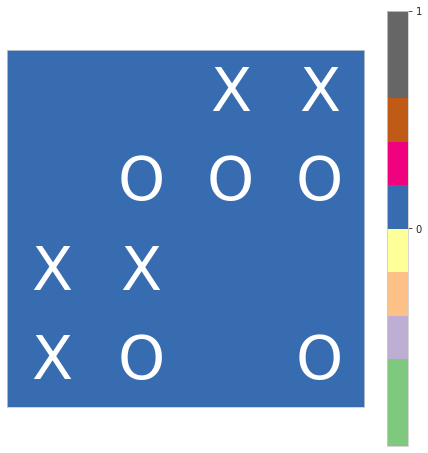

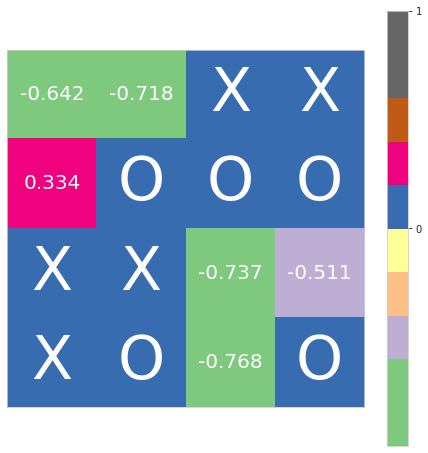

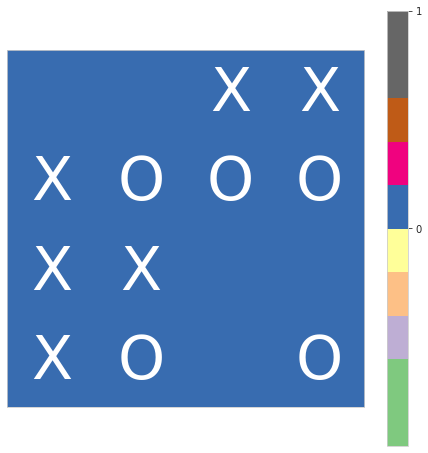

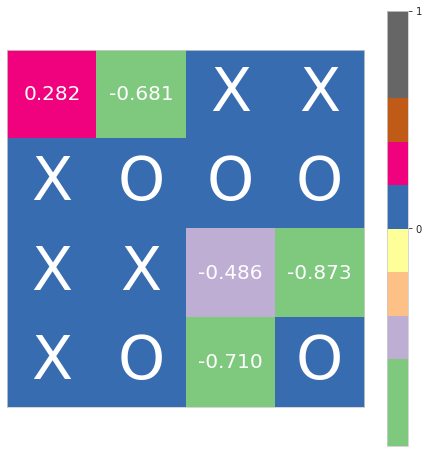

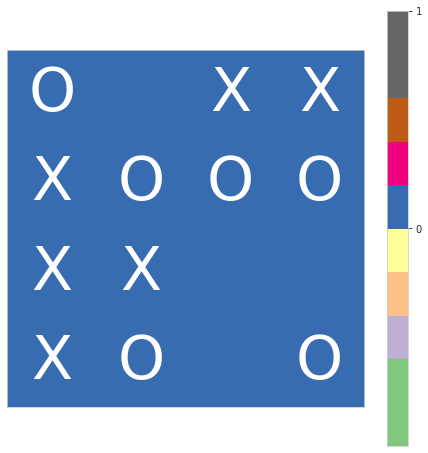

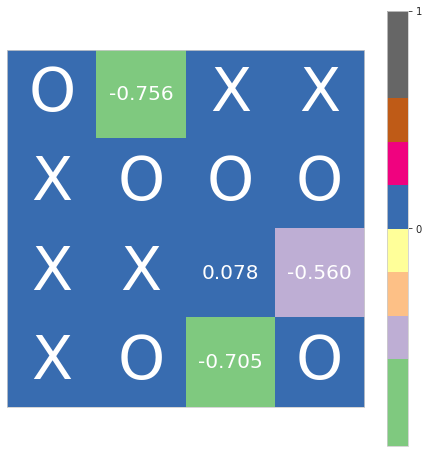

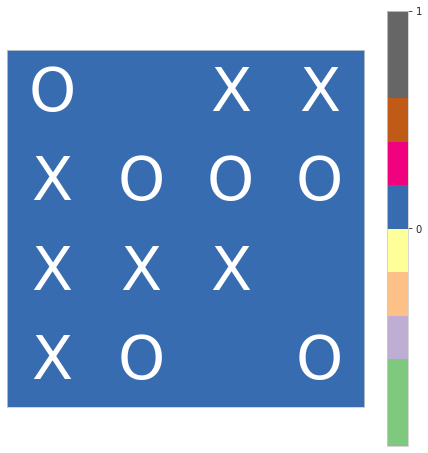

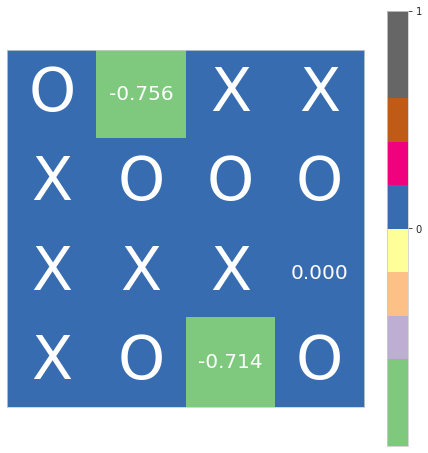

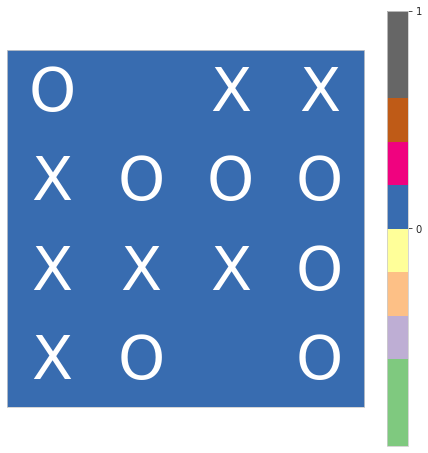

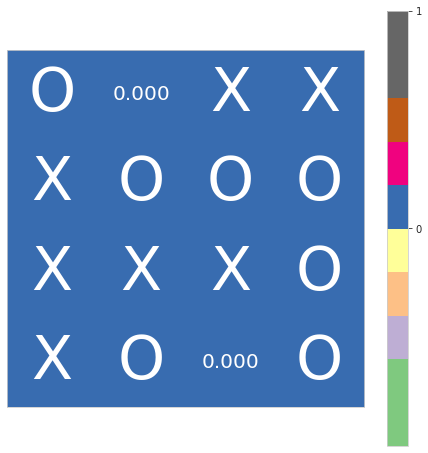

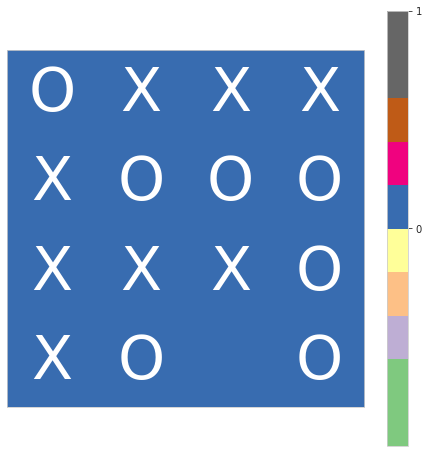

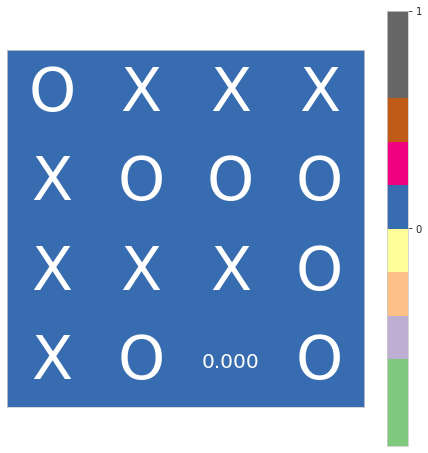

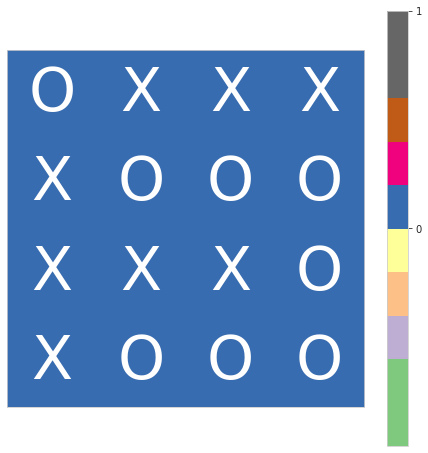

Ничья!


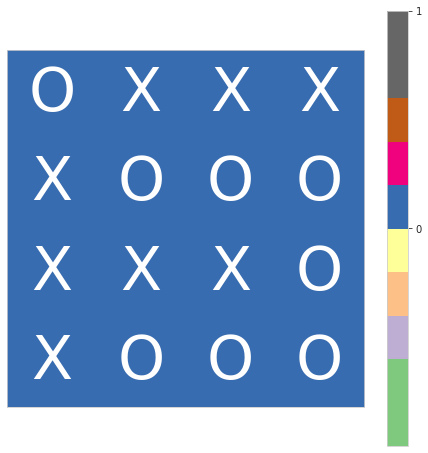

In [ ]:
plot_test_game(env, pi_crosses, pi_naughts, random_crosses=False, random_naughts=False, verbose=False, fontq=20, fontx=60)